In [4]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 30 19:41:59 2023

@author: jrjol
"""
from polygon import RESTClient

client = RESTClient(api_key="ocunxnOqC0pnltRqT3VkOiKeCmPE49L7")

import requests

url = "https://api.polygon.io/v2/aggs/ticker/DELL/range/1/day/2010-10-22/2023-10-23?adjusted=true&sort=asc&limit=5000&apiKey=ocunxnOqC0pnltRqT3VkOiKeCmPE49L7"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    print(data)
else:
    print("Failed to retrieve data. Status code:", response.status_code)
import pandas as pd

results = data["results"]
df = pd.DataFrame(results)
df = df[["o", "h", "l", "c"]]

df


{'ticker': 'DELL', 'queryCount': 1973, 'resultsCount': 1973, 'adjusted': True, 'results': [{'v': 13761703.0, 'vw': 14.5888, 'o': 14.71, 'c': 14.585, 'h': 14.71, 'l': 14.51, 't': 1287720000000, 'n': 40057}, {'v': 13180971.0, 'vw': 14.7507, 'o': 14.73, 'c': 14.71, 'h': 14.85, 'l': 14.65, 't': 1287979200000, 'n': 38728}, {'v': 17469823.0, 'vw': 14.5703, 'o': 14.64, 'c': 14.51, 'h': 14.7, 'l': 14.48, 't': 1288065600000, 'n': 48969}, {'v': 16312208.0, 'vw': 14.5841, 'o': 14.51, 'c': 14.67, 'h': 14.69, 'l': 14.45, 't': 1288152000000, 'n': 48721}, {'v': 16432171.0, 'vw': 14.5853, 'o': 14.77, 'c': 14.59, 'h': 14.77, 'l': 14.465, 't': 1288238400000, 'n': 53421}, {'v': 25605548.0, 'vw': 14.4355, 'o': 14.47, 'c': 14.395, 'h': 14.78, 'l': 14.19, 't': 1288324800000, 'n': 71059}, {'v': 18325356.0, 'vw': 14.4405, 'o': 14.54, 'c': 14.41, 'h': 14.7, 'l': 14.28, 't': 1288584000000, 'n': 57573}, {'v': 20066878.0, 'vw': 14.3283, 'o': 14.59, 'c': 14.365, 'h': 14.6, 'l': 14.1, 't': 1288670400000, 'n': 59879

,o,h,l,c
0,14.71,14.710,14.510,14.585
1,14.73,14.850,14.650,14.710
2,14.64,14.700,14.480,14.510
3,14.51,14.690,14.450,14.670
4,14.77,14.770,14.465,14.590
...,...,...,...,...
1968,67.26,68.645,66.700,67.900
1969,67.25,68.335,66.870,66.890
1970,67.24,68.680,66.785,67.030
1971,66.82,67.250,65.350,65.910


In [1]:
from datetime import date, datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import pytz
from polygon import RESTClient
from polygon.rest.models import (
    Agg,
    DailyOpenCloseAgg,
    GroupedDailyAgg,
    PreviousCloseAgg,
    Sort,
)
from polygon.rest.models.request import RequestOptionBuilder
from urllib3 import HTTPResponse


def get_client():
    return RESTClient("ocunxnOqC0pnltRqT3VkOiKeCmPE49L7")


# TODO: Account for market holidays and half-days
# TODO: Determine timezone from stock/equity ticker
def within_trading_hours(
    timestamp: Union[str, int, datetime, date], timezone: str
) -> bool:
    """
    Determine whether a given instant is within trading hours for a particular exchange.

    :param timestamp: The timestamp (in milliseconds) to be checked.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: True if the timestamp is within trading hours, False otherwise.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    if dt.weekday() < 5:
        opening_time = dt.replace(hour=9, minute=30, second=0, microsecond=0)
        closing_time = dt.replace(hour=16, minute=0, second=0, microsecond=0)
        return opening_time <= dt <= closing_time
    else:
        return False


# TODO: Determine timezone from stock/equity ticker
def parse_timestamp(timestamp: Union[str, int, datetime, date], timezone: str) -> str:
    """
    Parse a timestamp to a readable format for easy comparisons.

    :param timestamp: The timestamp (in milliseconds) to be formatted.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: Date-time representation in the following format: %Y-%m-%d %H:%M:%S %Z.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    return dt.strftime("%Y-%m-%d %H:%M:%S %Z")


def agg_to_dict(agg: Agg) -> dict[str, Union[None, float, int, bool]]:
    """
    Convert an aggregate object to a dictionary, and add any extra data that may be useful.

    :param agg: The aggregate object to parse.
    :return: Dictionary with keys corresponding to attributes of the object.
    """
    return {
        "open": agg.open,
        "high": agg.high,
        "low": agg.low,
        "close": agg.close,
        "volume": agg.volume,
        "vwap": agg.vwap,
        "timestamp": agg.timestamp,
        "datetime": parse_timestamp(agg.timestamp, "America/New_York"),
        "transactions": agg.transactions,
        "otc": agg.otc,
    }


def list_aggs(
    client: RESTClient,
    ticker: str,
    multiplier: int,
    timespan: str,
    # "from" is a keyword in python https://www.w3schools.com/python/python_ref_keywords.asp
    from_: Union[str, int, datetime, date],
    to: Union[str, int, datetime, date],
    include_extended_hours: bool = False,
    adjusted: Optional[bool] = None,
    sort: Optional[Union[str, Sort]] = None,
    limit: Optional[int] = None,
    params: Optional[Dict[str, Any]] = None,
    raw: bool = False,
    options: Optional[RequestOptionBuilder] = None,
) -> pd.DataFrame:
    """
    List aggregate bars for a ticker over a given date range in custom time window sizes.

    :param client: The RESTClient object to perform the request with.
    :param ticker: The ticker symbol.
    :param multiplier: The size of the timespan multiplier.
    :param timespan: The size of the time window.
    :param from_: The start of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param to: The end of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param include_extended_hours: True if pre-market and after-hours trading data are to be included, False otherwise.
    :param adjusted: Whether or not the results are adjusted for splits. By default, results are adjusted. Set this to false to get results that are NOT adjusted for splits.
    :param sort: Sort the results by timestamp. asc will return results in ascending order (oldest at the top), desc will return results in descending order (newest at the top).The end of the aggregate time window.
    :param limit: Limits the number of base aggregates queried to create the aggregate results. Max 50000 and Default 5000. Read more about how limit is used to calculate aggregate results in Polygon's on Aggregate Data API Improvements.
    :param params: Any additional query params.
    :param raw: Return raw object instead of results object.
    :return: Pandas DataFrame representation of aggregate objects.
    """
    aggs = []
    for a in client.list_aggs(
        ticker,
        multiplier,
        timespan,
        from_,
        to,
        adjusted=adjusted,
        sort=sort,
        limit=limit,
        params=params,
        raw=raw,
        options=options,
    ):
        if include_extended_hours or within_trading_hours(
            a.timestamp, "America/New_York"
        ):
            aggs.append(agg_to_dict(a))
    return pd.DataFrame(aggs)


print(
    list_aggs(
        get_client(), "AAPL", 1, "day", "2022-01-01", "2023-02-03", limit=50000
    )
)


Empty DataFrame
Columns: []
Index: []


In [27]:
from datetime import date, datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import pytz
from polygon import RESTClient
from polygon.rest.models import (
    Agg,
    DailyOpenCloseAgg,
    GroupedDailyAgg,
    PreviousCloseAgg,
    Sort,
)
from polygon.rest.models.request import RequestOptionBuilder
from urllib3 import HTTPResponse

import yfinance as yf
import pandas as pd

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta


# Function to get the Polygon RESTClient
def get_client():
    return RESTClient(
        "VoUAUxVML9mwSpopBIK7vPjIF_Y25Yk5"
    )  # Replace with your actual API key


# Function to get stock data for a specific company within a time window
def get_stock_data(client, ticker, start_date, end_date):
    stock_data = list_aggs(
        client, ticker, 3, "day", start_date, end_date, limit=50000
    )
    
    return stock_data




# TODO: Account for market holidays and half-days
# TODO: Determine timezone from stock/equity ticker
def within_trading_hours(
    timestamp: Union[str, int, datetime, date], timezone: str
) -> bool:
    """
    Determine whether a given instant is within trading hours for a particular exchange.

    :param timestamp: The timestamp (in milliseconds) to be checked.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: True if the timestamp is within trading hours, False otherwise.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    if dt.weekday() < 5:
        opening_time = dt.replace(hour=9, minute=30, second=0, microsecond=0)
        closing_time = dt.replace(hour=16, minute=0, second=0, microsecond=0)
        return opening_time <= dt <= closing_time
    else:
        return False


# TODO: Determine timezone from stock/equity ticker
def parse_timestamp(timestamp: Union[str, int, datetime, date], timezone: str) -> str:
    """
    Parse a timestamp to a readable format for easy comparisons.

    :param timestamp: The timestamp (in milliseconds) to be formatted.
    :param timezone: The timezone to check trading hours in, as a IANA Time Zone Database Name.
    :return: Date-time representation in the following format: %Y-%m-%d %H:%M:%S %Z.
    """
    dt = datetime.fromtimestamp(timestamp / 1000, tz=pytz.timezone(timezone))
    return dt.strftime("%Y-%m-%d %H:%M:%S %Z")


def agg_to_dict(agg: Agg) -> dict[str, Union[None, float, int, bool]]:
    """
    Convert an aggregate object to a dictionary, and add any extra data that may be useful.

    :param agg: The aggregate object to parse.
    :return: Dictionary with keys corresponding to attributes of the object.
    """
    return {
        "open": agg.open,
        "high": agg.high,
        "low": agg.low,
        "close": agg.close,
        "volume": agg.volume,
        "vwap": agg.vwap,
        "timestamp": agg.timestamp,
        "datetime": parse_timestamp(agg.timestamp, "America/New_York"),
        "transactions": agg.transactions,
        "otc": agg.otc,
    }


def list_aggs(
    client: RESTClient,
    ticker: str,
    multiplier: int,
    timespan: str,
    # "from" is a keyword in python https://www.w3schools.com/python/python_ref_keywords.asp
    from_: Union[str, int, datetime, date],
    to: Union[str, int, datetime, date],
    include_extended_hours: bool = False,
    adjusted: Optional[bool] = None,
    sort: Optional[Union[str, Sort]] = None,
    limit: Optional[int] = None,
    params: Optional[Dict[str, Any]] = None,
    raw: bool = False,
    options: Optional[RequestOptionBuilder] = None,
) -> pd.DataFrame:
    """
    List aggregate bars for a ticker over a given date range in custom time window sizes.

    :param client: The RESTClient object to perform the request with.
    :param ticker: The ticker symbol.
    :param multiplier: The size of the timespan multiplier.
    :param timespan: The size of the time window.
    :param from_: The start of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param to: The end of the aggregate time window as YYYY-MM-DD, a date, Unix MS Timestamp, or a datetime.
    :param include_extended_hours: True if pre-market and after-hours trading data are to be included, False otherwise.
    :param adjusted: Whether or not the results are adjusted for splits. By default, results are adjusted. Set this to false to get results that are NOT adjusted for splits.
    :param sort: Sort the results by timestamp. asc will return results in ascending order (oldest at the top), desc will return results in descending order (newest at the top).The end of the aggregate time window.
    :param limit: Limits the number of base aggregates queried to create the aggregate results. Max 50000 and Default 5000. Read more about how limit is used to calculate aggregate results in Polygon's on Aggregate Data API Improvements.
    :param params: Any additional query params.
    :param raw: Return raw object instead of results object.
    :return: Pandas DataFrame representation of aggregate objects.
    """
    aggs = []
    for a in client.list_aggs(
        ticker,
        multiplier,
        timespan,
        from_,
        to,
        adjusted=adjusted,
        sort=sort,
        limit=limit,
        params=params,
        raw=raw,
        options=options,
    ):
        if include_extended_hours or within_trading_hours(
            a.timestamp, "America/New_York"
        ):
            aggs.append(agg_to_dict(a))
    return pd.DataFrame(aggs)



Monte Carlo

[*********************100%%**********************]  3 of 3 completed


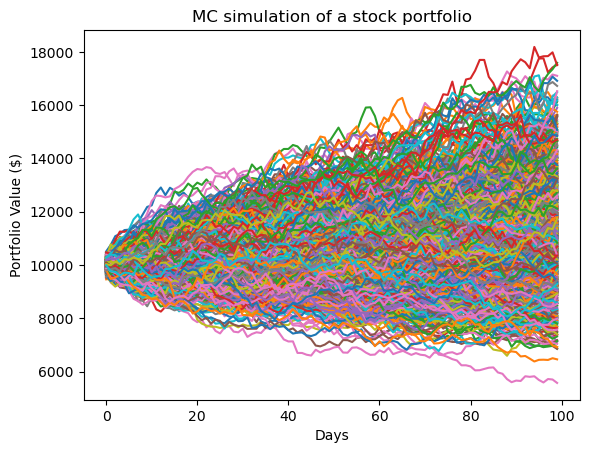

VaR_5 $1902.41
CVaR_5 $2435.02


In [33]:
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import yfinance as yf
import matplotlib.pyplot as plt

def get_data(stocks, start, end):
    df = yf.download(stocks, start, end)   
    df = df.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1)
    returns = df.pct_change()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

def monte_carlo_simulation(weights, mean_returns, cov_matrix, mc_sims, T, initial_portfolio):
    mean_matrix = np.full(shape=(T, len(weights)), fill_value=mean_returns)
    mean_matrix = mean_matrix.T

    portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

    for m in range(mc_sims):
        Z = np.random.normal(size=(T, len(weights)))
        L = np.linalg.cholesky(cov_matrix)
        daily_returns = mean_matrix + np.inner(L, Z)
        portfolio_sims[:, m] = np.cumprod(np.inner(weights, daily_returns.T) + 1) * initial_portfolio

    return portfolio_sims

def plot_portfolio_sims(portfolio_sims):
    plt.plot(portfolio_sims)
    plt.ylabel('Portfolio Value ($)')
    plt.xlabel('Days')
    plt.title('MC simulation of a stock portfolio')
    plt.show()

def mcVaR(returns, alpha=5, **kwargs):
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha, **kwargs)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5, **kwargs):
    if isinstance(returns, pd.Series):
        below_VaR = returns <= mcVaR(returns, alpha=alpha, **kwargs)
        return returns[below_VaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

# Set up portfolio
portfolio = ['AAPL', 'MSFT', 'AMZN']
weights = np.random.random(len(portfolio))
weights /= np.sum(weights)

# Setting start date as 300 days before today
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=500)

mean_returns, cov_matrix = get_data(portfolio, start_date, end_date)

# Monte Carlo Simulation
mc_sims = 1000
T = 100
initial_portfolio = 10000

portfolio_sims = monte_carlo_simulation(weights, mean_returns, cov_matrix, mc_sims, T, initial_portfolio)

# Plotting
plot_portfolio_sims(portfolio_sims)

# Calculate and print VaR and CVaR
port_results = pd.Series(portfolio_sims[-1, :])
VaR = initial_portfolio - mcVaR(port_results, alpha=5)
CVaR = initial_portfolio - mcCVaR(port_results, alpha=5)

print('VaR_5 ${}'.format(round(VaR, 2)))
print('CVaR_5 ${}'.format(round(CVaR, 2)))


return on investment (ROI) 



This script appears to be analyzing the performance of stocks in the S&P 500 index by calculating the return on investment (ROI) for a specific trading strategy related to ex-dividend dates.

Let's break down the script:

Web Scraping:

The script starts by scraping the list of S&P 500 companies from a Wikipedia page.
Fetching Dividend Data:

It then fetches dividend data for each company using the Yahoo Finance API (yf.Ticker(i).dividends), and stores the data in a dictionary called result_dict.
Filtering Tickers:

It filters out specific tickers ('BRK.B', 'BF.B') from the list of companies.
Calculating ROI:

For each remaining ticker, it iterates through the ex-dividend dates, retrieves stock price data for a specific time window (5 days after the ex-dividend date), and calculates the ROI for each trade.

It calculates the ROI using the formula: 
(
closing price on day 5
−
closing price on day 0
)
/
closing price on day 0
(closing price on day 5−closing price on day 0)/closing price on day 0.

The positive ROI trades and negative ROI trades are counted.

It calculates the success rate of the trading strategy (the proportion of positive trades) and the average ROI for all trades.

Let's break down the key variables:

positive: The count of trades with positive ROI.
negative: The count of trades with negative ROI.
All_ROIs: A list that stores the ROI for each trade.
all_trades: The total number of trades (positive + negative).
success_rate: The proportion of trades with positive ROI.
average: The average ROI for all trades.
The script essentially assesses the performance of a trading strategy related to ex-dividend dates for the selected S&P 500 stocks. The success rate and average ROI are used to evaluate the overall effectiveness of the strategy.

In [4]:
from datetime import date, datetime
from typing import Any, Dict, Iterator, List, Optional, Union

import pandas as pd
import pytz
from polygon import RESTClient
from polygon.rest.models import (
    Agg,
    DailyOpenCloseAgg,
    GroupedDailyAgg,
    PreviousCloseAgg,
    Sort,
)
from polygon.rest.models.request import RequestOptionBuilder
from urllib3 import HTTPResponse

import yfinance as yf
import pandas as pd

import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

url = 'https://en.wikipedia.org/w/index.php?title=List_of_S%26P_500_companies'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', {'id': 'constituents'})
tickerzz = []
for row in table.find_all('tr')[1:]:
    columns = row.find_all('td')
    ticker = columns[0].text.strip()
    tickerzz.append(ticker)

start = '2020-09-5'
end = '2023-10-29'
dictionary={}
data = pd.DataFrame()
for i in tickerzz:
    dividends = yf.Ticker(i).dividends

    if isinstance(dividends, pd.DataFrame) or isinstance(dividends, pd.Series):
        series = dividends.loc[start:end]
        series = series.rename(i)
        dictionary[i]=series
        data = pd.concat([data, series], axis=1)

result_dict = {}

for company_ticker, column in data.items():
    company_data = {}
    for index, row in column.items():
        if not pd.isna(row):
            
            company_data[index] = row
    company_series = pd.Series(company_data, name=company_ticker)
    result_dict[company_ticker] = company_series

All_ROIs=[]
positive=0
negative=0

#tickerzz = [ticker for ticker in tickerzz if ticker not in ['BRK.B', 'BF.B']]
ticker_series = pd.Series(tickerzz)
ticker_series = ticker_series[~ticker_series.isin(['BRK.B', 'BF.B'])]
tickerzz = ticker_series.tolist()
for i in tickerzz:
    company_exdividend_dates = result_dict[i]
    Numbers_of_dates_to_check = len(company_exdividend_dates)

    for ex_date in range(Numbers_of_dates_to_check):  # Iterate within the bounds!!
        date_index = company_exdividend_dates.index[ex_date]
        new_date = date_index + timedelta(days=5)
        new_date = new_date.strftime("%Y-%m-%d")
        date_index = date_index.strftime("%Y-%m-%d")
        stock_data = list_aggs(
            get_client(), i, 1, "minute", str(date_index), str(new_date), limit=50000
        )
        if not stock_data.empty:
            roi = (stock_data.iloc[131, 3] - stock_data.iloc[124, 0]) / stock_data.iloc[124, 0]
            All_ROIs.append(roi)
            if roi > 0:
                positive += 1
            else:
                negative += 1
all_trades=positive+negative
success_rate=positive/all_trades
average=sum(All_ROIs)/all_trades

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 1924-12-06 -> 2023-11-13)


a combination of LASSO regression and ARIMA time series forecasting



his script appears to implement a trading strategy using a combination of LASSO regression and ARIMA time series forecasting. Let me break down the key components and steps:

Data Retrieval:

The script starts by fetching historical price data for the SPY (S&P 500 ETF) from Alpaca's API using the alpaca_trade_api.
Feature Selection and LASSO Regression:

It selects specific features ('open', 'high', 'low', 'vwap') from the training data (df_training) and performs LASSO regression to find coefficients.
ARIMA Time Series Forecasting:

It uses the pmdarima library to perform auto ARIMA modeling on each feature separately (open, high, low, vwap).
Prediction and Trading Logic:

For each future iteration beyond the training data:
It predicts future values for each feature using ARIMA models.
It calculates the predicted closing price using the LASSO regression coefficients.
It tracks the actual closing price and calculates the absolute error between the predicted and actual closing prices.
It uses a simple trading strategy where it decides to buy if the predicted closing price is higher than the current closing price and no buying price is set. Once bought, it calculates the revenue when selling at the actual future closing price.
It keeps track of winning and losing trades, percentage of winners, and calculates average revenue per trade.
Model Re-training:

Every 14 iterations, it re-calculates LASSO coefficients to adapt to changing market conditions.
Metrics Monitoring:

It prints and updates various metrics during the trading simulation, such as the percentage of winners, revenue, average revenue per trade, number of trades, mean squared error (MSE), and Akaike Information Criterion (AIC) value.
It's important to note that this script is a simplified example and may not be suitable for actual trading without further validation, backtesting, and risk management considerations. Additionally, the effectiveness of the strategy heavily depends on the chosen features, model parameters, and the underlying assumptions about market behavior.

In [ ]:
import threading
import numpy as np
import pandas as pd
import alpaca_trade_api as alpaca
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import concurrent.futures
from sklearn.linear_model import LassoCV



alpaca_api = alpaca.REST(
    key_id='PK3TY1J6MQKONR6CFHCU',
    secret_key='QIbzNGaZsDEhMTLRycKlJlHEksBMnZaZFXIgdMnf', 
    base_url='https://data.alpaca.markets/v2',
    api_version='v2',
)

alpaca_df = alpaca_api.get_bars('SPY', alpaca.TimeFrame(30, alpaca.TimeFrameUnit.Minute), '2015-01-01', '2023-01-05').df

alpaca_df = alpaca_df.between_time('14:30', '21:00')


df_training = alpaca_df.iloc[0:18013]
df_test=alpaca_df.iloc[18014:25013]
all_actual_close=df_test['close']

### I have selected on these features, this can be changed to include: volume, trade_count##
X = df_training[['open', 'high', 'low', 'vwap']]
y = df_training['close']


lasso_cv = LassoCV(cv=5)


lasso_cv.fit(X, y)


print('Lasso coefficients:', lasso_cv.coef_)
print('Lasso intercept:', lasso_cv.intercept_)
print('Best alpha:', lasso_cv.alpha_)

coef = lasso_cv.coef_
open_coefficient=coef[0]
high_coefficient=coef[1]
low_coefficient=coef[2]
vwap_coefficient=coef[3]
alpha=lasso_cv.alpha_

interval_counter=0
Sum_of_errors=0
buy_price=0
Revenue=0
winning_trades=0
losing_trades=0

def ARIMA_PREDICTIONS(df_training):

    
    open_future = concurrent.futures.Future()
    high_future = concurrent.futures.Future()
    low_future = concurrent.futures.Future()
    #volume_future = concurrent.futures.Future()
    #trade_count_future = concurrent.futures.Future()
    vwap_future = concurrent.futures.Future()

    
    thread1 = threading.Thread(target=lambda: open_future.set_result(auto_arima((df_training.iloc[:,0]), seasonal=False, trace=True, max_q=3, max_d=3, max_p=3)), args=())
    thread2 = threading.Thread(target=lambda: high_future.set_result(auto_arima((df_training.iloc[:,1]), seasonal=False, trace=True, max_q=3, max_d=3, max_p=3)), args=())
    thread3 = threading.Thread(target=lambda: low_future.set_result(auto_arima((df_training.iloc[:,2]),  seasonal=False, trace=True, max_q=3, max_d=3, max_p=3)), args=())
    #thread4 = threading.Thread(target=lambda: volume_future.set_result(auto_arima((df_training.iloc[:,4]),  seasonal=False, trace=True, max_q=3, max_d=3, max_p=3)), args=())
    #thread5 = threading.Thread(target=lambda: trade_count_future.set_result(auto_arima((df_training.iloc[:,5]),  seasonal=False, trace=True, max_q=3, max_d=3, max_p=3)), args=())
    thread6 = threading.Thread(target=lambda: vwap_future.set_result(auto_arima((df_training.iloc[:,6]), seasonal=False, trace=True, max_q=3, max_d=3, max_p=3)), args=())

    thread1.start()
    thread2.start()
    thread3.start()
    #thread4.start()
    #thread5.start()
    thread6.start()

    thread1.join()
    thread2.join()
    thread3.join()
    #thread4.join()
    #thread5.join()
    thread6.join()

    
    open = open_future.result()
    high = high_future.result()
    low = low_future.result()
    #volume = volume_future.result()
    #trade_count = trade_count_future.result()
    vwap = vwap_future.result()

    
    open_p, open_d, open_q = open.order
    high_p, high_d, high_q = high.order
    low_p, low_d, low_q = low.order
    #volume_p, volume_d, volume_q = volume.order
    #trade_count_p, trade_count_d, trade_count_q = trade_count.order
    vwap_p, vwap_d, vwap_q = vwap.order
    
    
    open_model_fit = ARIMA(df_training.iloc[:,0], order=(open_p,open_d,open_q), seasonal_order=(0,0,0,0)).fit()
    high_model_fit = ARIMA(df_training.iloc[:,1], order=(high_p,high_d,high_q), seasonal_order=(0,0,0,0)).fit()
    low_model_fit = ARIMA(df_training.iloc[:,2], order=(low_p,low_d,low_q), seasonal_order=(0,0,0,0)).fit()
    #volume_model_fit = ARIMA(df_training.iloc[:,4], order=(volume_p,volume_d,volume_q), seasonal_order=(0,0,0,0)).fit()
    #trade_count_model_fit = ARIMA(df_training.iloc[:,5], order=(trade_count_p,trade_count_d,trade_count_q), seasonal_order=(0,0,0,0)).fit()
    vwap_model_fit = ARIMA(df_training.iloc[:,6], order=(vwap_p,vwap_d,vwap_q), seasonal_order=(0,0,0,0)).fit()
    
    ####
    forecast_open = open_model_fit.forecast(steps=1)
    open_pred = forecast_open.iloc[0]
    
    forecast_high = high_model_fit.forecast(steps=1)
    high_pred = forecast_high.iloc[0]
    
    forecast_low = low_model_fit.forecast(steps=1)
    low_pred = forecast_low.iloc[0]
    
    #forecast_volume = volume_model_fit.forecast(steps=1)
    #volume_pred = forecast_volume.iloc[0]
    
    #forecast_trade_count = trade_count_model_fit.forecast(steps=1)
    #trade_count_pred = forecast_trade_count.iloc[0]
    
    forecast_vwap = vwap_model_fit.forecast(steps=1)
    vwap_pred = forecast_vwap.iloc[0]
    
    return open_pred, high_pred, low_pred, vwap_pred

def LASSO_COEFF_CALCULATOR(df_training):
    X = df_training[['open', 'high', 'low', 'vwap']]
    y = df_training['close']

    
    lasso_cv = LassoCV(cv=5)

    lasso_cv.fit(X, y)

    coef = lasso_cv.coef_
    open_coefficient=coef[0]
    high_coefficient=coef[1]
    low_coefficient=coef[2]
    vwap_coefficient=coef[3]
    alpha=lasso_cv.alpha_
    
    return open_coefficient, high_coefficient, low_coefficient, vwap_coefficient, alpha
    
def LASSO_REGRESSOR(open_coefficient, high_coefficient, low_coefficient, vwap_coefficient, alpha, open_pred, high_pred, low_pred, vwap_pred):
    pred_close=open_coefficient*open_pred+high_coefficient*high_pred+low_coefficient*low_pred+vwap_coefficient*vwap_pred+alpha*(open_coefficient+high_coefficient+low_coefficient+vwap_coefficient)
    return pred_close



future_iterations=alpaca_df.shape[0]-df_training.shape[0]

all_y_pred=[]
all_pred_closes=[]
all_absoulte_errors=[]
Data_of_Percentage_winners=[]
Data_of_all_trades=[]



for i in range(0,future_iterations-1):
    
    df_training=alpaca_df.iloc[i:18013+i]
    
    actual_future_close=all_actual_close.iloc[i]
    
    current_close=alpaca_df.iloc[18013+i,3]
    
    open_pred, high_pred, low_pred, vwap_pred=ARIMA_PREDICTIONS(df_training)
    
    pred_close=LASSO_REGRESSOR(open_coefficient, high_coefficient, low_coefficient, vwap_coefficient, alpha, open_pred, high_pred, low_pred, vwap_pred)
    
    interval_counter+=1
    
    if interval_counter==14:
        open_coefficient, high_coefficient, low_coefficient, vwap_coefficient, alpha=LASSO_COEFF_CALCULATOR(df_training)
        interval_counter=0
    
    n_params = 4
    absoulte_error=abs(pred_close-actual_future_close)
    all_absoulte_errors.append(absoulte_error)
    Sum_of_errors=Sum_of_errors+absoulte_error
    MSE=Sum_of_errors/(i+1)
    aic_value = 2 * n_params + interval_counter * np.log(Sum_of_errors / interval_counter)

    if pred_close>current_close and buy_price==0:
        buy_price=current_close
    
    if buy_price>0:
        sell_price=actual_future_close
        
        money_made=sell_price-buy_price
        buy_price=0
        
        Data_of_all_trades.append(money_made)
        
        Revenue=Revenue+money_made
        
        if money_made>0:
            winning_trades+=1
        else:
            losing_trades+=1
            
        Percentage_winners=winning_trades/(winning_trades+losing_trades)*100
        Data_of_Percentage_winners.append(Percentage_winners)
        
        Average_revenue_per_trade=Revenue/(winning_trades+losing_trades)
    
    
    print('How many iterations: ', interval_counter)
    print('Percentage of winners: ', Data_of_Percentage_winners)
    print('All trades: ', Data_of_all_trades)
    print('Current Revenue: ', Revenue)
    print('Average revuene per trade so far: ', Average_revenue_per_trade)
    print('Number of trades made: ', (winning_trades+losing_trades), '. Of these, ', winning_trades, ' are winners, and, ', losing_trades, ' are losing trades.')
    print('MSE: ', MSE)
    print('AIC value:', aic_value)
    

LSTM